In [1]:
import torch
import transformers
from timm.data.constants import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
from torch.utils.data import DataLoader
from torchvision.transforms import v2
import os
import pprint
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

In [2]:
transformers.__version__, torch.__version__

('4.40.2', '2.1.1')

In [3]:
# Device and paths:
device = 'cuda'
physionet_dir = '/datasets/work/hb-mlaifsp-mm/work/archive/physionet.org/files'  # Where MIMIC-CXR, MIMIC-CXR-JPG, and MIMIC-IV-ED are stored.
dataset_dir = '/scratch3/nic261/datasets'  # Some outputs of prepare_data() will be stored here.
database_path = '/scratch3/nic261/database/cxrmate_ed.db'  # The DuckDB database used to manage the tables of the dataset will be saved here.
mimic_cxr_jpg_dir = '/scratch3/nic261/datasets/physionet.org/files/mimic-cxr-jpg/2.0.0/files'  # The path to the JPG images of MIMIC-CXR-JPG. This could be different to physionet_dir to leverage faster storage.

In [4]:
# Download model checkpoint:
model = transformers.AutoModel.from_pretrained('aehrc/cxrmate-ed', trust_remote_code=True).to(device=device)
model.eval()

# Download tokenizer:
tokenizer = transformers.PreTrainedTokenizerFast.from_pretrained('aehrc/cxrmate-ed')
os.environ['TOKENIZERS_PARALLELISM'] = 'false'

/scratch3/nic261/environments/cxrmate_ed/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
A new version of the following files was downloaded from https://huggingface.co/aehrc/cxrmate-ed:
- modelling_uniformer.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/aehrc/cxrmate-ed:
- tables.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/aehrc/cxrmate-ed:
- dataset.py
. Make sure to double-check they do not co

In [5]:
# Image transforms:
image_size = 384
test_transforms = v2.Compose(
    [
        v2.Grayscale(num_output_channels=3),
        v2.Resize(
            size=image_size, 
            antialias=True,
            interpolation=v2.InterpolationMode.BICUBIC,
        ),
        v2.CenterCrop(size=[image_size, image_size]),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=IMAGENET_DEFAULT_MEAN, std=IMAGENET_DEFAULT_STD),
    ]
)

In [6]:
# Prepare the MIMIC-CXR & MIMIC-IV-ED dataset:
model.prepare_data(
    physionet_dir=physionet_dir,
    dataset_dir=dataset_dir,
    database_path=database_path,
)

# Get the test set dataset & dataloader:
test_set = model.get_dataset('test', test_transforms, database_path, mimic_cxr_jpg_dir)
test_dataloader = DataLoader(
    test_set,
    batch_size=1, 
    num_workers=5,
    shuffle=True,  # Shuffle so that a different example is shown everytime the notebook is ran.
    collate_fn=model.collate_fn,
    pin_memory=True,
)

No. of examples: 1624.
No. of training dicom_ids, study_ids, & subject_ids: 2872, 1624, & 280.


In [7]:
# Get an example:
batch = next(iter(test_dataloader))
        
# Show the batch:
pp = pprint.PrettyPrinter(indent=2)
pp.pprint(batch)

{ 'edstays_index_value_feats': tensor([[[0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 1.]]]),
  'edstays_index_value_mask': tensor([[1]], dtype=torch.int32),
  'edstays_index_value_time_delta': tensor([[[0.5829]]]),
  'edstays_index_value_token_type_ids': tensor([[1]]),
  'findings': [ 'PA and lateral views of the chest: Interstitial opacities '
                'within the right upper lobe are thought to represent '
                'recurrent pneumonia. Pneumonia was noted in this area on ___ '
                'but had essentially cleared on ___. The right lower lobe '
                'nodule is unchanged in size through ___. There is no '
                'pneumothorax. A small right pleural effusion and right apical '
                'scarring persists. The neo esophagus is not distended. The '
                'mediastinal silhouette is normal in contour.'

/apps/python/3.12.0/lib/python3.12/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/apps/python/3.12.0/lib/python3.12/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


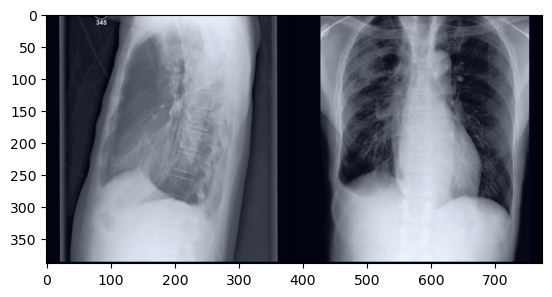

In [8]:
# Show the images for the study:
plt.imshow(make_grid(batch['images'][0], normalize=True).permute(1, 2, 0))

In [9]:
# Move tensors in the batch to the device:
for key, value in batch.items():
    if isinstance(value, torch.Tensor):
        batch[key] = value.to(device)

In [19]:
# Convert the patient data in the batch into embeddings:
inputs_embeds, attention_mask, token_type_ids, position_ids, bos_token_ids = model.prepare_inputs(tokenizer=tokenizer, **batch)
    
# Generate reports:
output_ids = model.generate(
    input_ids=bos_token_ids,
    decoder_inputs_embeds=inputs_embeds,
    decoder_token_type_ids=token_type_ids,
    prompt_attention_mask=attention_mask,
    prompt_position_ids=position_ids,
    special_token_ids=[tokenizer.sep_token_id],
    token_type_id_sections=model.decoder.config.section_ids,
    max_length=256,
    num_beams=4,
    return_dict_in_generate=True,
)['sequences']


In [20]:
# Findings and impression section:
findings, impression = model.split_and_decode_sections(output_ids, [tokenizer.sep_token_id, tokenizer.eos_token_id], tokenizer)
for i,j in zip(findings, impression):
    print(f'Findings:\t{i}\nImpression:\t{j}\n\n')

Findings:	PA and lateral views of the chest. There is consolidation in the right upper lobe compatible with pneumonia. There is a small right pleural effusion. There is increased opacity in the right pleural region. The left lung is grossly clear. The cardiomediastinal and hilar contours are normal. There is no pneumothorax. No acute osseous abnormalities seen.
Impression:	Right upper lobe consolidation compatible with pneumonia in the correct clinical setting.


